# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

## Background
Photonic crystals (PhC) are micro/nano artificial atoms composed of periodically perturbed refractive indices dielectric material, which can manipulate the propagation of electromagnetic (EM) waves in a similar manner to how actual crystals manipulate electron waves. The periodic symmetry and Maxwell equations guarantee that the eigenmodes of EM waves can be held in PhC are represented by photonic band structures. One popular method to analyze the band structures of photonic crystals is to apply the Hamiltonian formalism, however, the method to select Hamiltonian basis has been left unrevealed in the majority of related papers. This will be the main purpose of our project.

## Generative Model: The Hamiltonian Matrix
The Hamiltonian matrix consists of coupling parameters that describe the interaction between different Bloch waves in the basis. At each value of $(k_x,k_y)$, the energy levels can be obtained by diagonalizing the Hamiltonian matrix and finding its eigenvalues. Due to the C4 symmetry of our square lattice, the allowed basis sizes are 5, 9, 13,...

Right now, this package allows you to infer the coupling parameters in a 5 basis model: 5 Bloch waves at $\Gamma$ point and its four surrounding symmetric points in $k-$space, whoses interaction can be described by 6 coupling parameters.

![title](reference_img/5-basis-doodle.png)

$U_{10},U_{11}$ and $U_{20}$ represent couplings between Bloch waves at different $k$ points, $\epsilon_0$ being the energy of the Bloch wave at the $\Gamma$ point, $\epsilon_x$ being the energy of other Bloch waves along $k_x$, $\epsilon_y$ being the energy of other Bloch waves along $k_y$. Let $P_1$ be the $\Gamma$ point, $P_2,P_3,P_4,P_5$ be the 4 points surrounding it by a clock-wise order starting at the point below the $\Gamma$ point. If we describe the model in the basis of $\{ P_1,P_2,P_3,P_4,P_5\}$, then the corresponding Hamiltonian matrix is:
$$ H =  \begin{pmatrix} \epsilon_0 & U_{10}& U_{10}& U_{10}& U_{10} \\ U_{10}& \epsilon_y & U_{11}& U_{20}& U_{11} \\ U_{10}& U_{11}& \epsilon_x & U_{11}& U_{20} \\ U_{10}& U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{10}& U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

The matrix is inherently diagonalizable and has the eigenvalues $\{ e_0,e_1,e_2,e_3,e_4\}$. 

From the measurement data, the energy mode at $\Gamma$ point is always too weak to detect. Therefore, one can simplify the model further to include basis of 4 k-vectors $\{P_2,P_3,P_4,P_5\}$ only. Our reduced Hamiltonian matrix becomes 
$$ H_{reduced} =  \begin{pmatrix} \epsilon_y & U_{11}& U_{20}& U_{11} \\ U_{11}& \epsilon_x & U_{11}& U_{20} \\ U_{20}&U_{11}& \epsilon_y & U_{11}\\ U_{11}&U_{20}& U_{11}  & \epsilon_x  \end{pmatrix}$$

And the eigenvalues $\{e_1,e_2,e_3,e_4\}$ represent 4 energy bands of the photonic crystal.

### Multiple Lorentzian Peak Model of the energy spectrum

In real measurement, 4 energy bands of the photonic crystals appear as four peaks in the frequency-intensity line plot. Therefore, our model for the energy spectrum is a multiple Lorentzian peak model where the peak positions are $\{e_1,e_2,e_3,e_4\}$.  The background $A_0$, amplitudes of four peaks $A_1, A_2, A_3, A_4$ and the peak width $W_1, W_2, W_3, W_4$ are the nuisance parameters that we will marginalize over.

$$ y_{predicted} = A_0 + \sum_1^4 A_i \text{Lorentzian}(e_i, W_i)$$

Firstly, we need to choose the priors for the parameters. For the coupling parameters $U_{11}$ and $U_{20}$, we know their lower and upper bounds from previous experiments (Reference ?). For the peak background and amplitudes, they are bounded by zero and the saturated intensity of the CCD detector. For the peak width, it is also bounded by the resolution in frequency of the laser and (?)  Since other these bounds we don't have any other information about the distributions of these parameters, in this package, we used uniform priors for all parameters.

$$\theta_n \sim \text{Uniform} (\theta_{n,min},\theta_{n,max})$$

for $\theta_n$ in $\{U_{11}, U_{20}, A_0, A_1, A_2, A_3, A_4, \sigma_L \}$. Note that for the uncoupling energies $\epsilon_x$ and $\epsilon_y$, we can extract their exact values from the (reference?) and use them as prior information.

Secondly, we consider all the uncertainty sources in measuring the light intensity such as beam profile, CCD sensitivity,...(?) These uncertainties are all Gaussian-like, thus, our likelihood is also well-described by Gaussian distribution:

$$y \sim \text{Gaussian} (y_{predicted}, \sigma_y)$$

## Using the photonic-hamiltonian package

### Load the data file

Before using the package, please make sure that the data is converted into .nc format

Our io_data.py script provides the $\textbf{load_data(filename)}$ function which exports the data in .nc format into an xarray with data labels 'normf', 'y1', 'y2', 'y3', 'y4', which indicates four repeating measurement results

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor

from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_singleKspectrum.nc')

We can plot this data to visualize how the four peaks look like in a real measurement

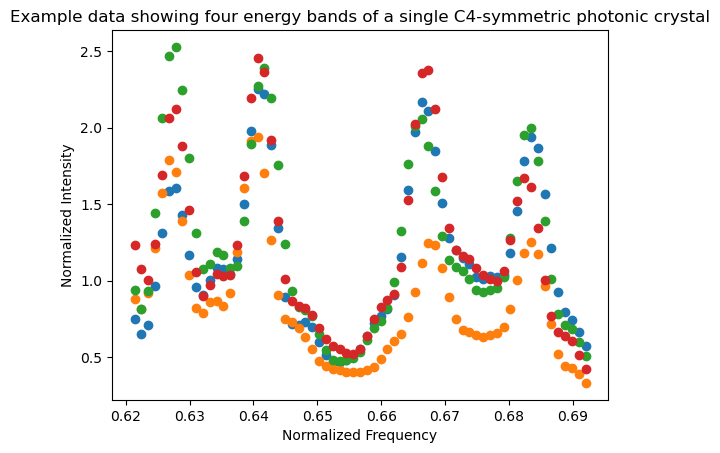

In [2]:
freq = real_data['normf'].to_numpy()
intensity = np.zeros((4,len(freq)))
intensity[:] = [real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

### Inference fit using pymc

In the package, the Model.py script has two functions: Hamiltonian_model and prediction_model

$\textbf{Hamiltonian_model(data, prior_bounds)}$ function:
* It is used to define, diagonalize the Hamiltonian matrix, and build a multi Lorentzian peak model from the matrix's eigenvalues. You can use this pymc model for sampling, plotting the posterior, or finding the maximum a posteriori (MAP) point to extract fit parameters.
* Its input parameters are data extracted and formatted by io.py, and a dictionary which maps parameters' names ('u11', 'u20', 'e0', 'de', 'A0', 'A1', 'A2', 'A3' , 'A4', 'W1', 'W2', 'W3', 'W4', 'sigma_y') to their corresponding prior types and coefficients.

$\textbf{prediction_model(theta, freq)}$ function:
 * It calculates the fitted intensity for a given set of fitting parameters
 * Its input parameters are the normalized frequency and a list of fitting parameters in the order [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]

In [3]:
from photonic_hamiltonian.inference import Model

#### Inference on simulated data

To test if running our model gives a reasonable result for parameter estimation, we first generate a simulated data with given values for all the parameters

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

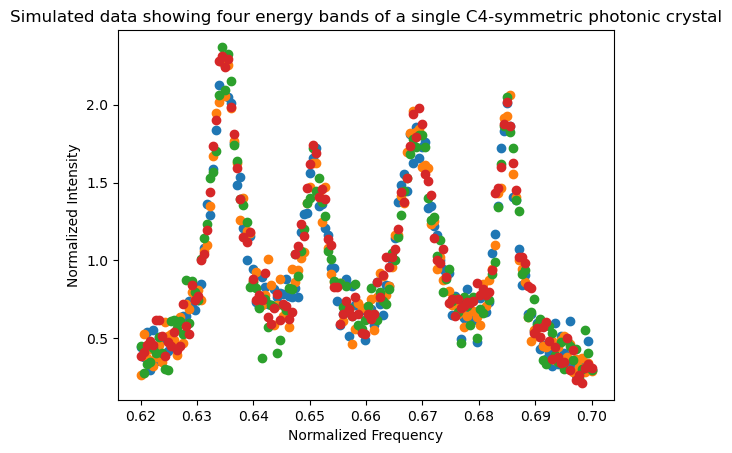

In [4]:
# Create simulated data
N = 150
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.008
u20 = 5e-5
e0 = 0.66
de = 0.015
A0 = 0.3
[A1,A2,A3,A4] = [1.9,1.2,1.5,1.6]
[W1,W2,W3,W4] = [0.003,0.0026,0.0036,0.002]
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
#create normalized intensity
line = Model.prediction_model(theta, simu_normf)

#create noise
sigma_noise = 0.1

#create data array
simu_data = xr.Dataset(data_vars = {'y1': ('normf', line + np.random.normal(0, sigma_noise, N) ),
                                    'y2': ('normf', line + np.random.normal(0, sigma_noise, N) ),
                                    'y3': ('normf', line + np.random.normal(0, sigma_noise, N) ),
                                    'y4': ('normf', line + np.random.normal(0, sigma_noise, N) )},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
simu_intensity = np.zeros((4,len(simu_normf)))
simu_intensity[:] = [simu_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

From the raw data, we can guess some reasonable bounds for our priors.

In [14]:
#guess the prior bounds
prior_W = [0.001, 0.005]
prior_A = [1, 2.2]
simu_priors = {'u11':('Uniform', [0.0075, 0.0085]),
               'u20':('Uniform', [0, 0.0001]),
               'e0':('Uniform', [0.65, 0.67]),
               'de':('Uniform', [0.01, 0.02]),
               'A0':('Uniform', [0.1, 0.5]),
               'A1':('Uniform', prior_A),
               'A2':('Uniform', prior_A),
               'A3':('Uniform', prior_A),
               'A4':('Uniform', prior_A),
               'W1':('Uniform', prior_W), 
               'W2':('Uniform', prior_W),
               'W3':('Uniform', prior_W),
               'W4':('Uniform', prior_W),
               'sigma_y':('Uniform', [0.05,0.15])}

#create the model 
simu_ham_model = Model.Hamiltonian_model(simu_data, simu_priors)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 119 seconds.


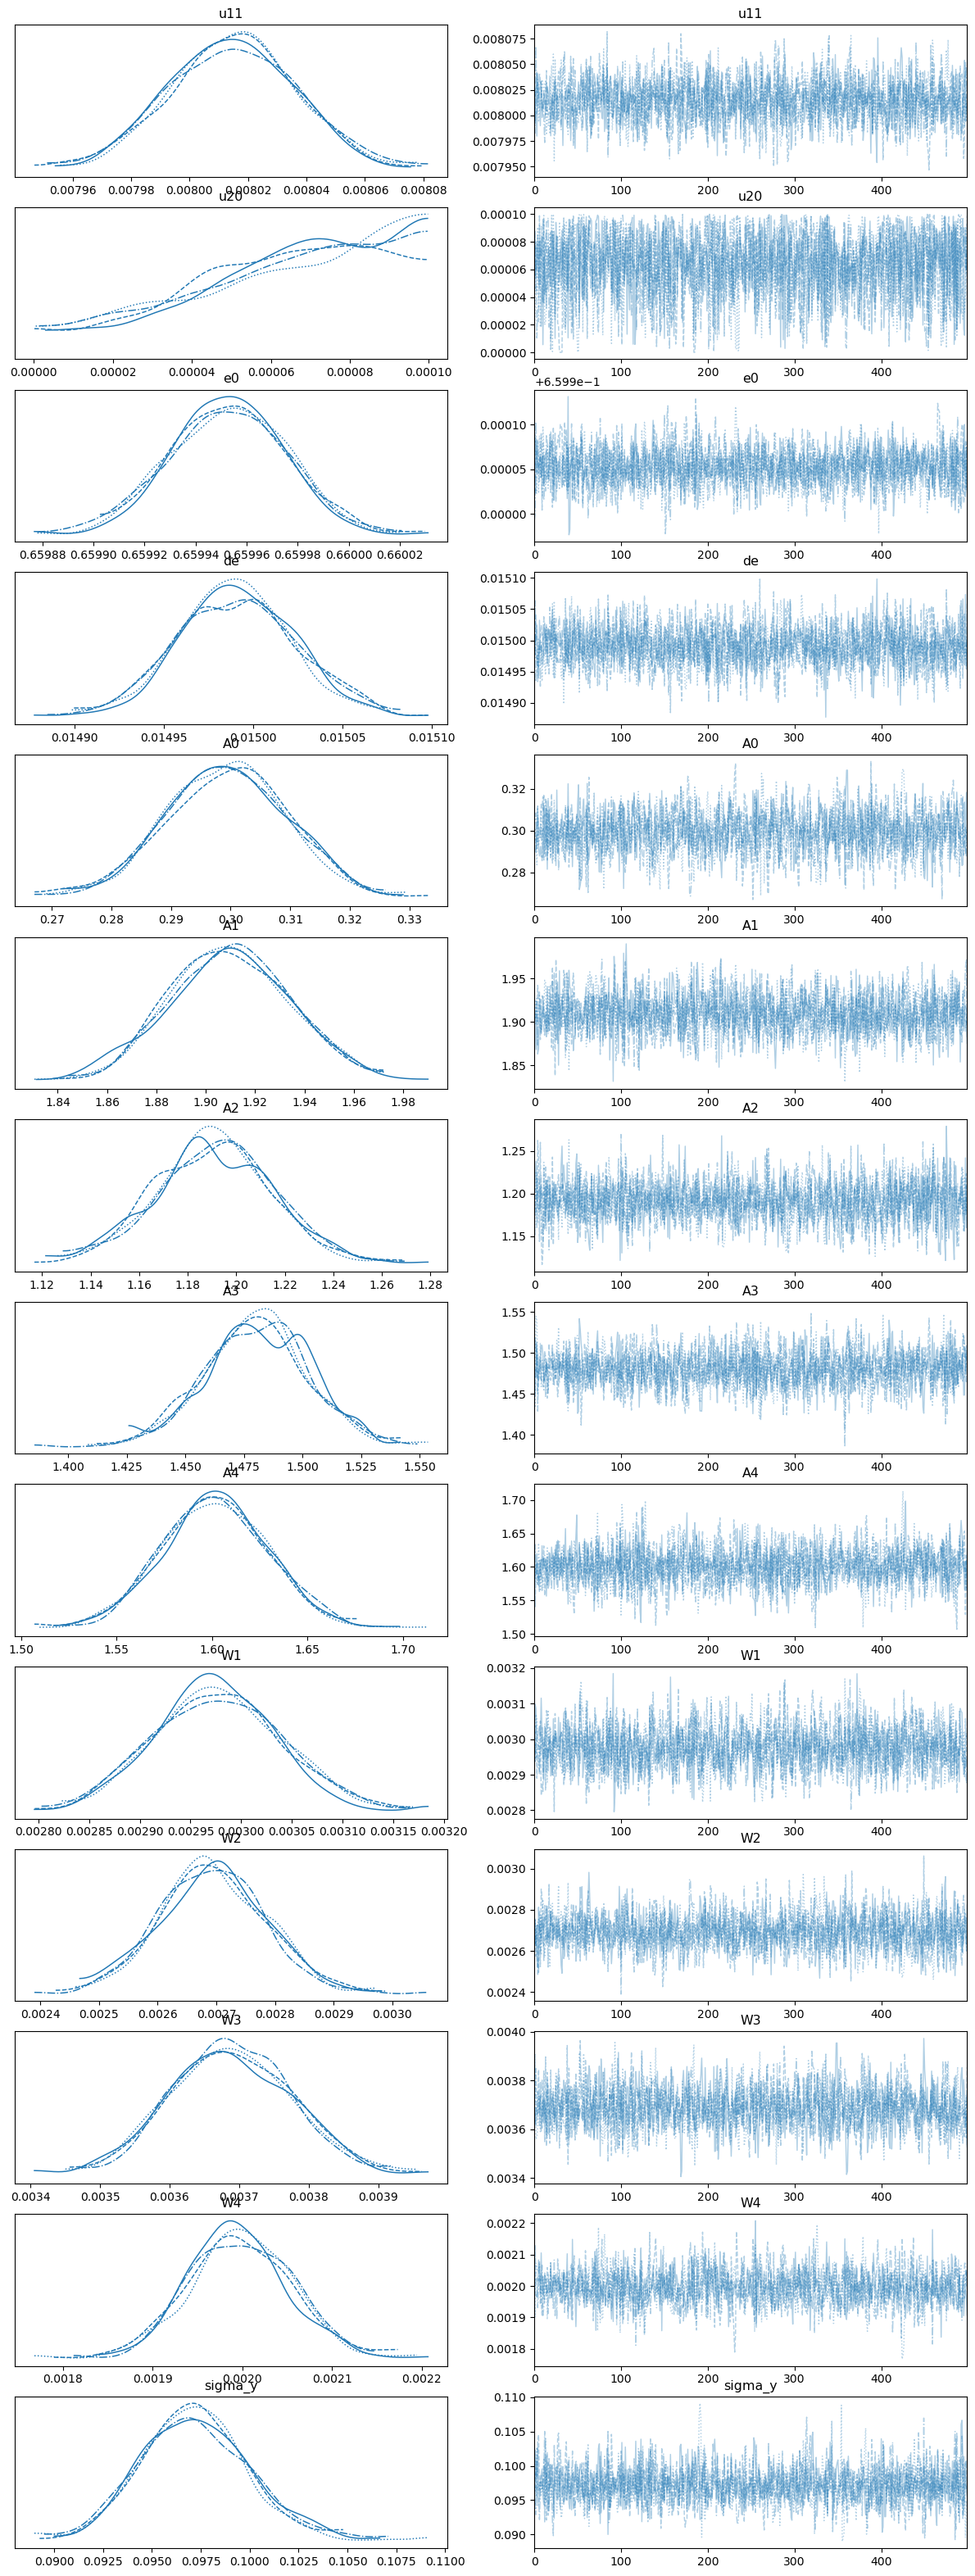

In [15]:
with simu_ham_model:
    simu_idata = pm.sample(500)

az.plot_trace(simu_idata, figsize=(15,40));

In [16]:
#summary the fitting results
simu_summary = az.summary(simu_idata,round_to=8)
display(simu_summary)

mean        sd    hdi_3%   hdi_97%     mcse_mean       mcse_sd  \
u11      0.008015  0.000022  0.007974  0.008054  4.300000e-07  3.100000e-07   
u20      0.000063  0.000025  0.000018  0.000100  5.200000e-07  3.700000e-07   
e0       0.659953  0.000022  0.659913  0.659995  4.300000e-07  3.000000e-07   
de       0.014991  0.000033  0.014935  0.015059  6.400000e-07  4.500000e-07   
A0       0.299310  0.010368  0.280015  0.318118  2.437600e-04  1.723900e-04   
A1       1.909836  0.024160  1.865740  1.955290  4.837500e-04  3.429100e-04   
A2       1.190966  0.024400  1.141637  1.234660  5.049500e-04  3.571000e-04   
A3       1.480643  0.022111  1.438765  1.521744  4.832400e-04  3.427800e-04   
A4       1.601498  0.028092  1.549053  1.653376  6.004200e-04  4.250500e-04   
W1       0.002977  0.000062  0.002863  0.003091  1.320000e-06  9.400000e-07   
W2       0.002694  0.000090  0.002520  0.002857  2.080000e-06  1.470000e-06   
W3       0.003689  0.000088  0.003529  0.003856  1.860000e-06  1.320000e-06   
W4       0.001997  0.000058  0.001893  0.002105  1.340000e-06  9.500000e-07   
sigma_y  0.097209  0.002795  0.092085  0.102464  5.887000e-05  4.191000e-05   

            ess_bulk     ess_tail     r_hat  
u11      2464.829814  1338.014903  1.001167  
u20      2251.043002  1272.158220  1.003733  
e0       2749.631236  1436.608362  1.003314  
de       2606.513703  1583.213264  1.002605  
A0       1819.761668  1293.238779  1.000256  
A1       2502.408866  1429.324596  1.001584  
A2       2331.899287  1484.050338  1.001952  
A3       2107.737309  1571.191079  1.001461  
A4       2206.783920  1390.237571  1.000072  
W1       2203.665043  1742.349000  1.002200  
W2       1874.379619  1547.032526  1.000878  
W3       2247.439804  1528.994722  1.002148  
W4       1878.751545  1545.212642  0.999963  
sigma_y  2336.493436  1410.111025  1.001462

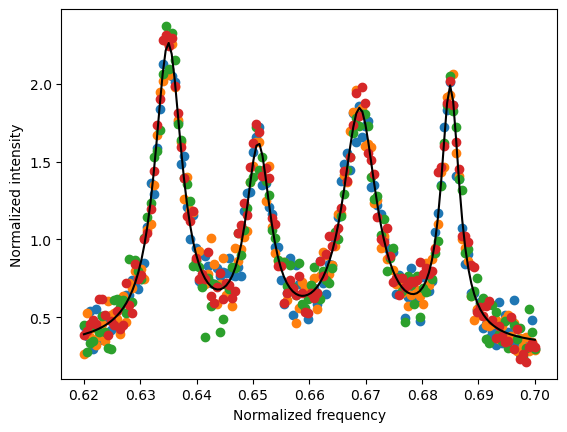

In [17]:
#plot data with the fitting curve
import pytensor.tensor as pt
u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = simu_summary['mean'].values
simu_theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
model_predictions = Model.prediction_model(simu_theta, simu_normf)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(simu_normf, simu_intensity.T, 'o')
plt.plot(simu_normf, model_predictions, 'k');

We can see that all these marginalized posteriors are peaked at the correct values of parameters that we used to generate the simulated data. Thus, our package works reasonably well with the simulated data.

#### Inference on real data

Similar to what we did with the simulated data, we need to look at the raw data, guess the bounds for peak parameters and then sample with generative model.

In [10]:
#guess the prior bounds
prior_A = [0.5, 2.5]
prior_W = [0.001, 0.03]
priors = simu_priors = {'u11':('Uniform', [0.005, 0.01]),
               'u20':('Uniform', [0, 0.005]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Uniform', [0, 1]),
               'A1':('Uniform', prior_A),
               'A2':('Uniform', prior_A),
               'A3':('Uniform', prior_A),
               'A4':('Uniform', prior_A),
               'W1':('Uniform', prior_W), 
               'W2':('Uniform', prior_W),
               'W3':('Uniform', prior_W),
               'W4':('Uniform', prior_W),
               'sigma_y':('Uniform', [0.1,0.5])}

#create the model 
ham_model = Model.Hamiltonian_model(real_data, priors)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 133 seconds.


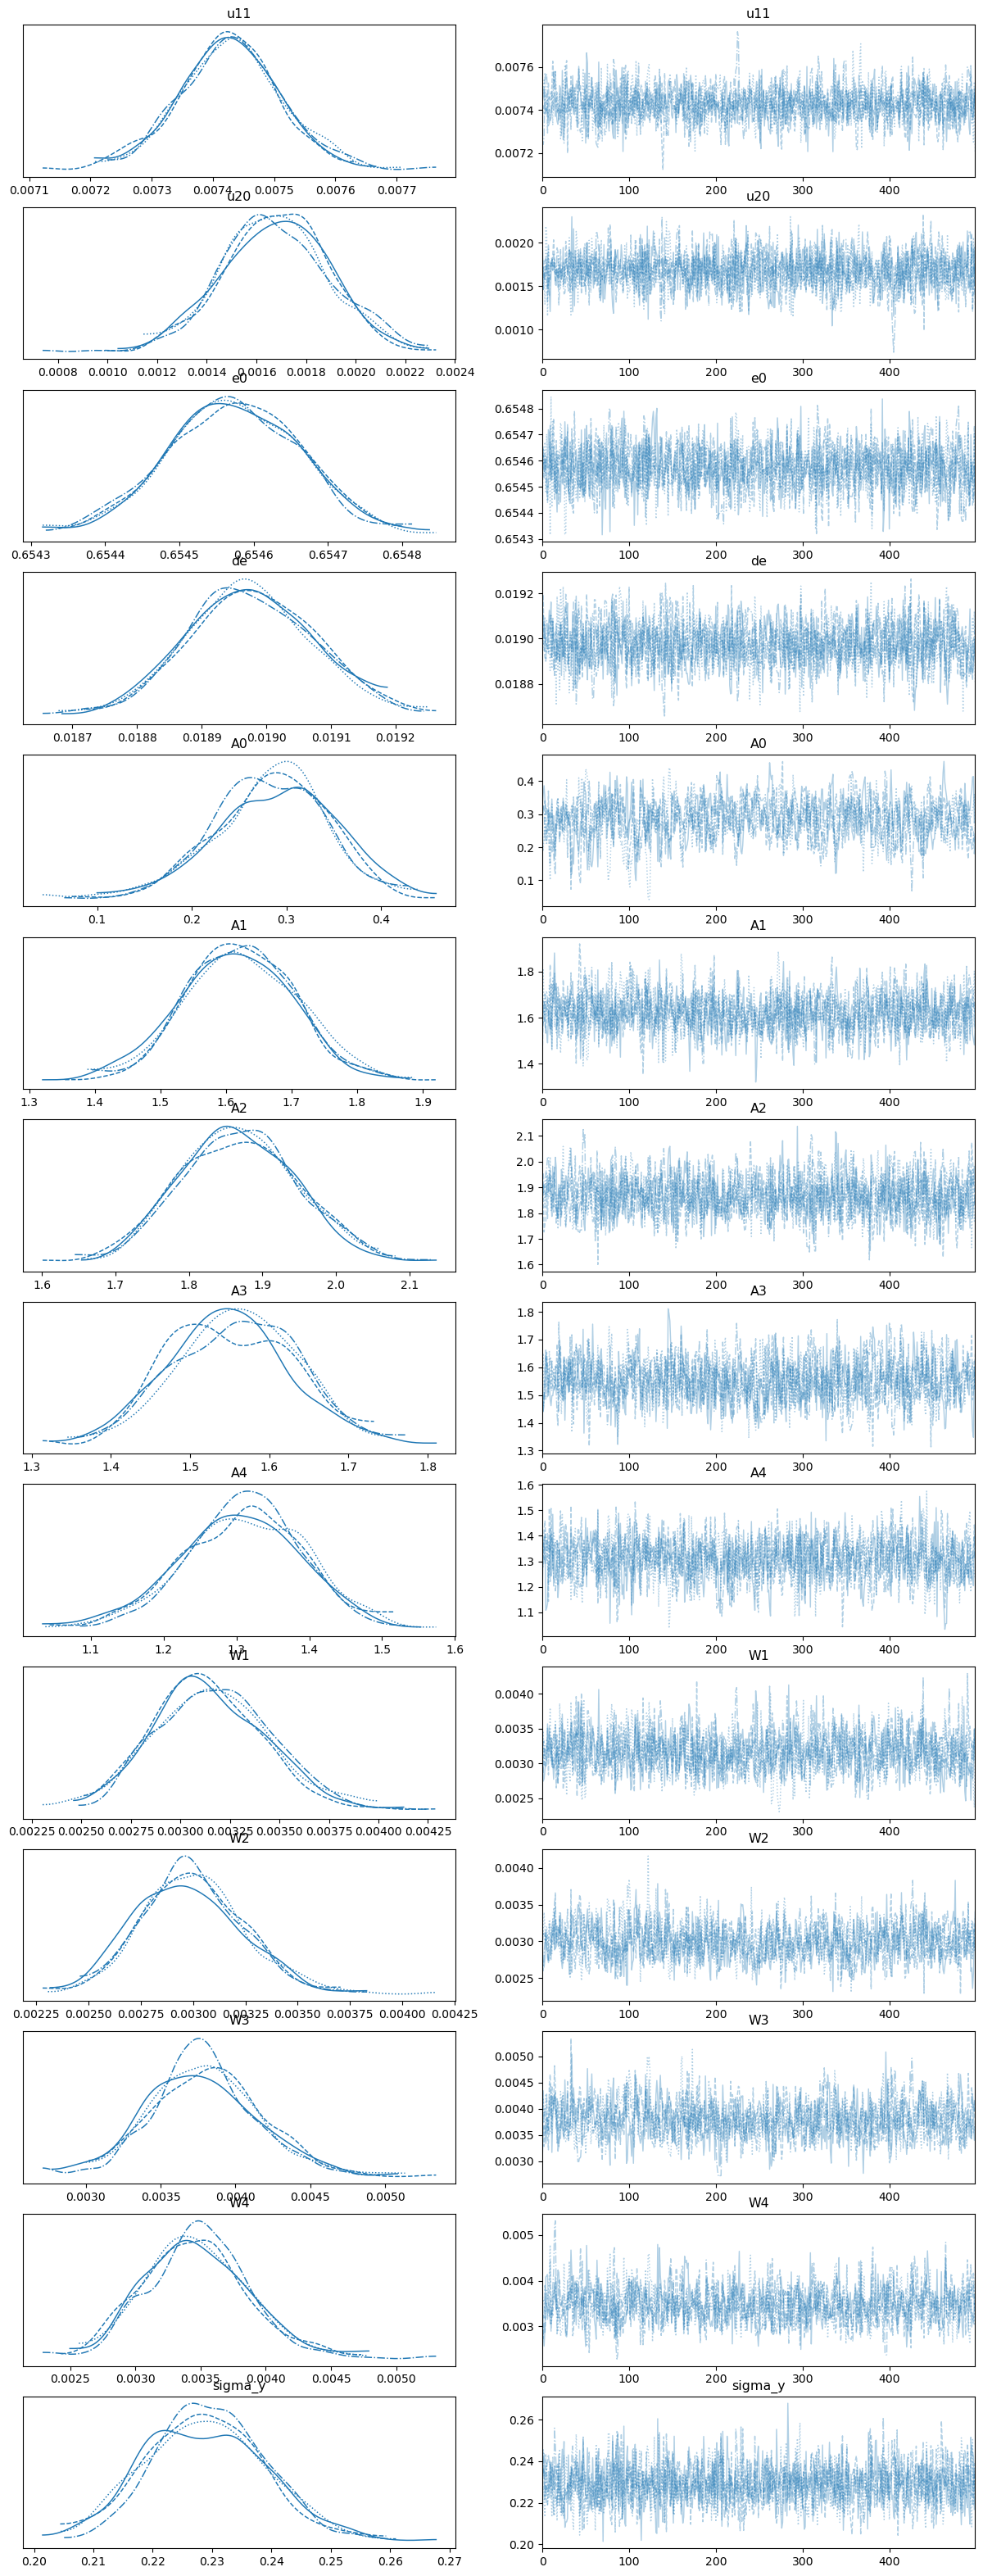

In [11]:
with ham_model:
    idata = pm.sample(500)

az.plot_trace(idata, figsize=(15,40));

In [12]:
#summary the fitting results
summary = az.summary(idata)
display(summary)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
u11      0.007  0.000   0.007    0.008      0.000    0.000    1617.0   
u20      0.002  0.000   0.001    0.002      0.000    0.000    1699.0   
e0       0.655  0.000   0.654    0.655      0.000    0.000    1499.0   
de       0.019  0.000   0.019    0.019      0.000    0.000    1571.0   
A0       0.285  0.062   0.177    0.408      0.003    0.002     607.0   
A1       1.620  0.085   1.454    1.778      0.002    0.002    1360.0   
A2       1.867  0.080   1.726    2.019      0.002    0.002    1398.0   
A3       1.554  0.078   1.412    1.705      0.002    0.002    1080.0   
A4       1.309  0.083   1.150    1.468      0.002    0.002    1143.0   
W1       0.003  0.000   0.003    0.004      0.000    0.000    1298.0   
W2       0.003  0.000   0.003    0.003      0.000    0.000    1049.0   
W3       0.004  0.000   0.003    0.004      0.000    0.000     902.0   
W4       0.003  0.000   0.003    0.004      0.000    0.000    1146.0   
sigma_y  0.229  0.010   0.210    0.247      0.000    0.000    1975.0   

         ess_tail  r_hat  
u11        1309.0   1.00  
u20        1292.0   1.00  
e0         1204.0   1.00  
de         1399.0   1.00  
A0          785.0   1.01  
A1         1473.0   1.00  
A2         1278.0   1.00  
A3         1264.0   1.00  
A4          926.0   1.00  
W1         1427.0   1.00  
W2         1137.0   1.01  
W3         1003.0   1.00  
W4         1360.0   1.00  
sigma_y    1361.0   1.00

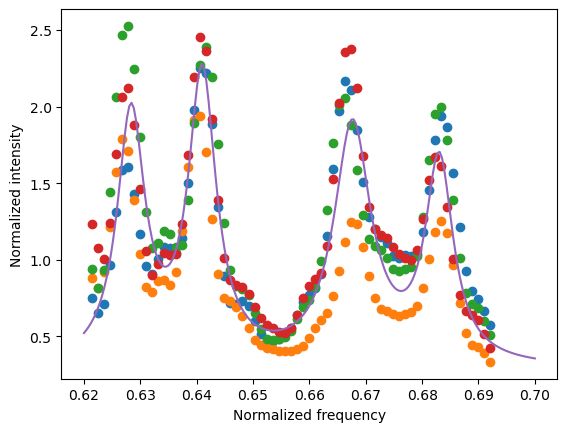

In [18]:
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = summary['mean'].values
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
model_predictions = Model.prediction_model(theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions)